# Install and import libraries

In [1]:
!pip install datasets evaluate accelerate
!pip install causal-conv1d>=1.1.0
!pip install mamba-ssm
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━

In [2]:
!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig /usr/lib64-nvidia

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link



In [3]:
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 61.6 MB/s eta 0:00:00


In [4]:
import os
import random
import json
import pandas as pd
import regex as re
import string
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from collections import namedtuple
from dataclasses import dataclass, field, asdict
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from mamba_ssm.utils.hf import load_config_hf, load_state_dict_hf
from huggingface_hub import HfApi

from underthesea import word_tokenize
from underthesea import text_normalize

import evaluate
import numpy as np
from datasets import load_dataset
from datasets import DatasetDict, Features, Dataset, Value, ClassLabel
from transformers import Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, TrainingArguments

In [31]:
from huggingface_hub import notebook_login
notebook_login()

# Data

In [6]:
data = pd.read_csv('/content/sentimentVN.csv')
data.head()

,content,label,start
0,Áo bao đẹp ạ!,POS,5
1,Tuyệt vời,POS,5
2,2day ao khong giong trong,NEG,1
3,"Mùi thơm,bôi lên da mềm da",POS,5
4,"Vải đẹp, dày dặn",POS,5


In [7]:
data = data.drop_duplicates("content")
data = data.dropna()

In [8]:
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE) # Unicode emojis.

def clean_text(text):
  text = text.lower()
  text = re.sub(emoji_pattern, " ", text)
  text = re.sub(r'([a-z]+?)\1+',r'\1', text)  # 'aaaabbb' --> 'ab'
  text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
  text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

  text = text.strip()
  while text.endswith(tuple(string.punctuation+string.whitespace)):
    text = text[:-1]
  while text.startswith(tuple(string.punctuation+string.whitespace)):
    text = text[1:]

  text = text.translate(str.maketrans('', '', string.punctuation))
  text = re.sub(r"\s+", " ", text)

  text = text_normalize(text)
  text = word_tokenize(text, format="text")

  return text

In [10]:
data['corpus'] = data['content'].map(lambda text: clean_text(text))
data.head()

,content,label,start,corpus
0,Áo bao đẹp ạ!,POS,5,áo bao đẹp ạ
1,Tuyệt vời,POS,5,tuyệt_vời
2,2day ao khong giong trong,NEG,1,2 day ao khong_giong trong
3,"Mùi thơm,bôi lên da mềm da",POS,5,mùi thơm bôi lên da mềm da
4,"Vải đẹp, dày dặn",POS,5,vải đẹp dày dặn


In [11]:
corpus_list = data['corpus'].tolist()
label_list = data['label'].tolist()

In [12]:
data_list = [{'corpus': corpus, 'label': label} for corpus, label in zip(corpus_list, label_list)]

In [13]:
# Chia dữ liệu thành 80% train và 20% test
train_size = int(0.8 * len(data_list))
test_size = len(data_list) - train_size

# Tạo features cho dataset
features = Features({
    "corpus": Value(dtype="string"),
    "label": ClassLabel(names=["POS", "NEG", "NEU"])
})

# Tạo dataset train và test
train_dataset = Dataset.from_list(data_list[:train_size], features=features)
test_dataset = Dataset.from_list(data_list[train_size:], features=features)

# Tạo DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
})

In [14]:
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['corpus', 'label'],
        num_rows: 21212
    })
    test: Dataset({
        features: ['corpus', 'label'],
        num_rows: 5304
    })
})


# EDA

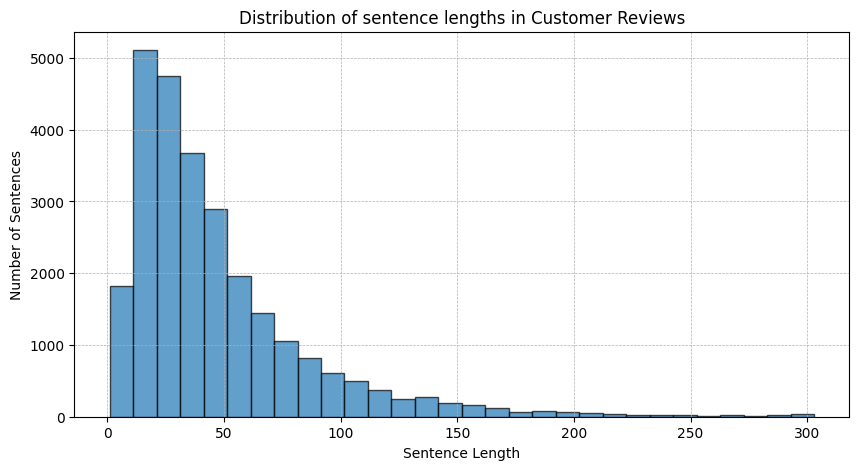

In [15]:
lengths = data['content'].apply(len)

plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of sentence lengths in Customer Reviews')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

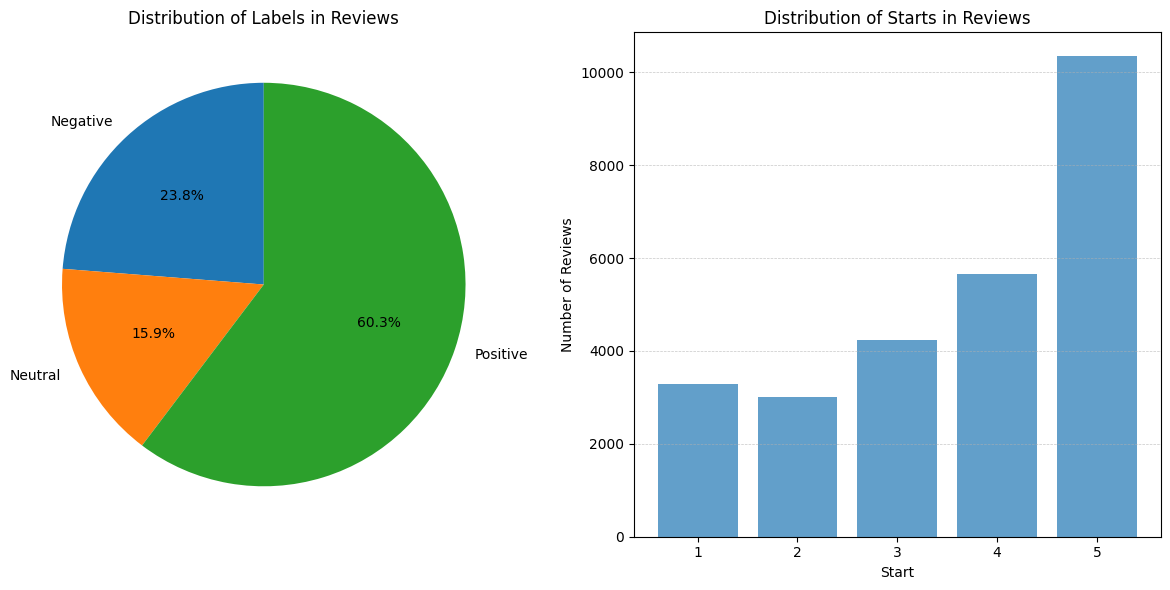

In [16]:
label_counts = data['label'].value_counts().sort_index()
start_counts = data['start'].value_counts().sort_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

labels = ['Negative', 'Neutral', 'Positive']
ax[0].pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Distribution of Labels in Reviews')

starts = [1, 2, 3, 4, 5]  # updated topics
ax[1].bar(starts, start_counts, alpha=0.7)
ax[1].set_title('Distribution of Starts in Reviews')
ax[1].set_xlabel('Start')
ax[1].set_ylabel('Number of Reviews')
ax[1].grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plots
plt.tight_layout()
plt.show()

# Build Custom Mamba Model for Text Classification

In [17]:
# Config class của Mamba tham khảo từ: https://github.com/state-spaces/mamba/blob/main/mamba_ssm/models/config_mamba.py
@dataclass
class MambaConfig:
  d_model: int = 2_560
  n_layer: int = 64
  vocab_size: int = 50_277
  ssm_cfg: dict = field(default_factory=dict)
  rms_norm: bool = True
  residual_in_fp32: bool = True
  fused_add_norm: bool = True
  pad_vocab_size_multiple: int = 8
  tie_embeddings: bool = True

  def to_json_string(self):
    return json.dumps(asdict(self))

  def to_dict(self):
    return asdict(self)

In [18]:
# Định nghĩa lớp Head để phân loại
class MambaClassificationHead(nn.Module):
  def __init__(self, d_model, num_classes, **kwargs):
    super(MambaClassificationHead, self).__init__()
    # Dùng 1 lớp tuyến tính để phân loại dựa trên đầu vào có kích thước d_model và num_classes cần phân loại
    self.classification_head = nn.Linear(d_model, num_classes, **kwargs)

  def forward(self, hidden_states):
    return self.classification_head(hidden_states)

In [19]:
class MambaTextClassification(MambaLMHeadModel):
  def __init__(
      self,
      config: MambaConfig,
      initializer_cfg = None,
      device = None,
      dtype = None,
  ) -> None:
      super().__init__(config, initializer_cfg, device, dtype)

      # Tạo 1 đầu phân loại dùng MambaClassificationHead với kích thước đầu vào là d_model và số lớp là 3
      self.classification_head = MambaClassificationHead(d_model=config.d_model, num_classes=3)

      del self.lm_head

  def forward(self, input_ids, attention_mask=None, labels=None):
    # Truyền input_ids qua model gốc để nhận hidden_states
    hidden_states = self.backbone(input_ids)

    # Lấy trung bình của hidden_states theo chiều thứ 2 để tạo ra [CLS] feature đại diện
    mean_hidden_states = hidden_states.mean(dim=1)

    # Đưa mean_hidden_states qua đầu phân loại để nhận logits
    logits = self.classification_head(mean_hidden_states)

    if labels is None:
      ClassificationOutput = namedtuple("ClassificationOutput", ["logits"])
      return ClassificationOutput(logits=logits)
    else:
      ClassificationOutput = namedtuple("ClassificationOutput", ["loss", "logits"])

      # Sử dụng CrossEntropyLoss để tính loss
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits, labels)

      return ClassificationOutput(loss=loss, logits=logits)

  def predict(self, text, tokenizer, id2label=None):
    input_ids = torch.tensor(tokenizer(text)['input_ids'], device='cuda')[None]
    with torch.no_grad():
      logits = self.forward(input_ids).logits[0]
      label = np.argmax(logits.cpu().numpy())

    if id2label is not None:
      return id2label[label]
    else:
      return label

  @classmethod
  def from_pretrained(cls, pretrained_model_name, device=None, dtype=None, **kwargs):
    # Tải pretrained model
    config_data = load_config_hf(pretrained_model_name)
    config = MambaConfig(**config_data)

    model = cls(config, device=device, dtype=dtype, **kwargs)

    model_state_dict = load_state_dict_hf(pretrained_model_name, device=device, dtype=dtype)
    model.load_state_dict(model_state_dict, strict=False)

    print("Newly initialized embedding:", set(model.state_dict().keys()) - set(model_state_dict.keys()))
    return model

In [20]:
# Tải mamba model
model = MambaTextClassification.from_pretrained("state-spaces/mamba-130m")
model.to("cuda")

# Tải tokenizer của mô hình Mamba từ mô hình gpt-neox-20b.
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
# Đặt id của token pad bằng id của token eos trong tokenizer.
tokenizer.pad_token_id = tokenizer.eos_token_id

config.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/517M [00:00<?, ?B/s]

Newly initialized embedding: {'classification_head.classification_head.weight', 'classification_head.classification_head.bias'}


tokenizer_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/457k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Preprocess data

In [21]:
def preprocess_data(examples):
  samples = tokenizer(examples["corpus"], truncation=True)
  # Không cần attention_mask
  # Cụ thể hơn về token masking của mamba có thể tham khảo: https://github.com/state-spaces/mamba/issues/49
  samples.pop('attention_mask')
  return samples

In [22]:
tokenized_data = dataset_dict.map(preprocess_data, batched=True)

Map:   0%|          | 0/21212 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/5304 [00:00<?, ? examples/s]

In [23]:
random.seed(42)

train_dataset = tokenized_data["train"]
test_dataset = tokenized_data["test"]

# Tạo tập evaluation để đánh giá trong lúc train
# Do số lượng tập test nhỏ nên chỉ lấy mẫu 20% tập dữ liệu test để đánh giá
total_samples = len(test_dataset)
eval_samples = int(0.2 * total_samples)
eval_indices = random.sample(range(total_samples), eval_samples)
eval_dataset = test_dataset.select(eval_indices)

# Evaluation metric

In [24]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  predictions, labels = eval_pred

  predictions = np.argmax(predictions, axis=1)

  return accuracy.compute(predictions=predictions, references=labels)

# Training

In [25]:
class MambaTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    input_ids = inputs.pop("input_ids")
    labels = inputs.pop("labels")

    outputs = model(input_ids=input_ids, labels=labels)

    loss = outputs.loss

    return (loss, outputs) if return_outputs else loss

  def save_model(self, output_dir=None, _internal_call=False):
    if output_dir is None:
      output_dir = self.args.output_dir

    if not os.path.exists(output_dir):
      os.makedirs(output_dir)

    torch.save(self.model.state_dict(), f"{output_dir}/pytorch_model.bin")

    self.tokenizer.save_pretrained(output_dir)

    with open(f'{output_dir}/config.json', 'w') as f:
      json.dump(self.model.config.to_dict(), f)

In [26]:
# Định nghĩa tên project để log thông tin quá trình huấn luyện trên wandb
os.environ["WANDB_PROJECT"] = "mamba_test_sentimentVN_v1"

In [27]:
# Định nghĩa các tham số huấn luyện trong đối tượng TrainingArguments
# Tham khảo: https://huggingface.co/docs/transformers/main_classes/trainer

training_args = TrainingArguments(
    output_dir="mamba_text_classification_v1",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    warmup_ratio=0.01,  # Tỉ lệ tăng dần lr trong giai đoạn warmup
    lr_scheduler_type="cosine",
    report_to="wandb",
    evaluation_strategy="steps",  # Xác định chiến lược đánh giá sau mỗi steps
    eval_steps=0.1,
    save_strategy="steps",  # Xác định khi nào lưu trạng thái của mô hình
    save_steps=0.1,
    logging_strategy="steps",  # Xác định khi nào in thông tin log
    logging_steps=1,
    push_to_hub=True,  # Push kết quả train lên Hub
    load_best_model_at_end=True,  # Load model có kết quả eval tốt nhất trong quá trình train
)

In [32]:
trainer = MambaTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

In [34]:
trainer.push_to_hub(commit_message="Training complete")

pytorch_model.bin:   0%|          | 0.00/517M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/wterrrr/mamba_text_classification_v1/commit/41195a1980aedfe68d676ebf37df3d5b8e5f0cff', commit_message='Training complete', commit_description='', oid='41195a1980aedfe68d676ebf37df3d5b8e5f0cff', pr_url=None, pr_revision=None, pr_num=None)

# Run testing

In [35]:
outputs = trainer.predict(test_dataset)

Step,Training Loss,Validation Loss,Accuracy
5303,0.255500,0.586363,0.766038
10606,0.443700,0.600482,0.790566
15909,0.662000,0.585810,0.793396
21212,0.199200,0.685358,0.797170
26515,0.849800,0.807276,0.789623
31818,0.002500,1.073148,0.783019
37121,0.745300,1.243690,0.776415


In [36]:
print(outputs.metrics)

{'test_loss': 1.7013585567474365, 'test_accuracy': 0.7462292609351433, 'test_runtime': 45.6609, 'test_samples_per_second': 116.161, 'test_steps_per_second': 7.271}


# Load and inference model from Hub

In [37]:
model = MambaTextClassification.from_pretrained("wterrrr/mamba_text_classification_v1")
model.to("cuda")

tokenizer = AutoTokenizer.from_pretrained("wterrrr/mamba_text_classification_v1")
tokenizer.pad_token_id = tokenizer.eos_token_id

config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/517M [00:00<?, ?B/s]

Newly initialized embedding: set()


tokenizer_config.json:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [38]:
id2label = {1: "NEG", 0: "POS", 2: "NEU"}

In [39]:
text = dataset_dict['test'][0]['corpus']
label = dataset_dict['test'][0]['label']

In [40]:
response = model.predict(text, tokenizer, id2label)

In [41]:
print(f'Classify: {text}\nGT: {id2label[label]}\nPredict: {response}')

Classify: giao sản_phẩm áo bị dính màu sao ko kiểm_tra hàng roi giao cho khách vậy shop làm_ăn có trách_nhiệm xíu nha
GT: NEG
Predict: NEG
